In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 12)    #set figure size for the notebook

Option 1: <b> geotiler </b><br>

http://wrobell.it-zone.org/geotiler/intro.html

In [4]:
import geotiler

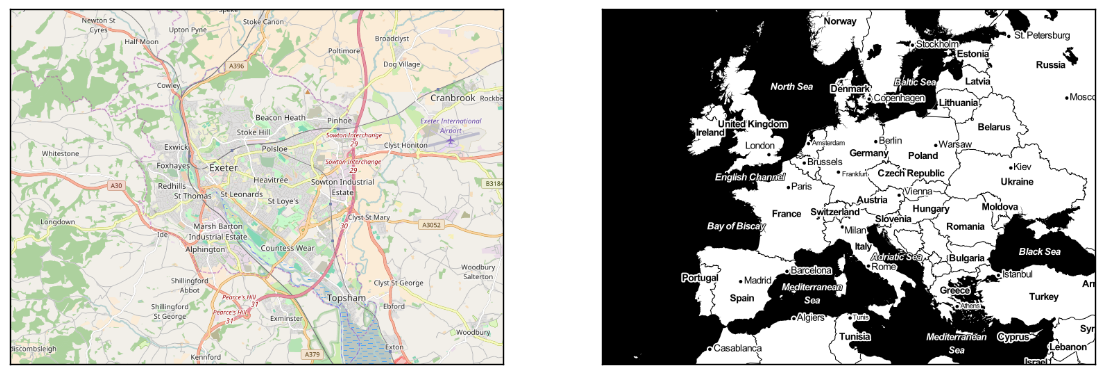

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)   #initialize 2 subplots within the figure

#load map first subplot: Exeter
m1 = geotiler.Map(center=(-3.51,50.72), zoom=12, size=(712,512))          # size affect the map geographical extend
m1.provider = geotiler.find_provider('osm')
image1 = geotiler.render_map(m1)
ax1.set_xticks([]) 
ax1.set_yticks([]) 
ax1.imshow(image1)

# 2nd map: Europe
m2 = geotiler.Map(center=(10,49), zoom=4, size=(712,512))
m2.provider = geotiler.find_provider('stamen-toner')
image2 = geotiler.render_map(m2)
ax2.set_xticks([]) 
ax2.set_yticks([]) 
ax2.imshow(image2)

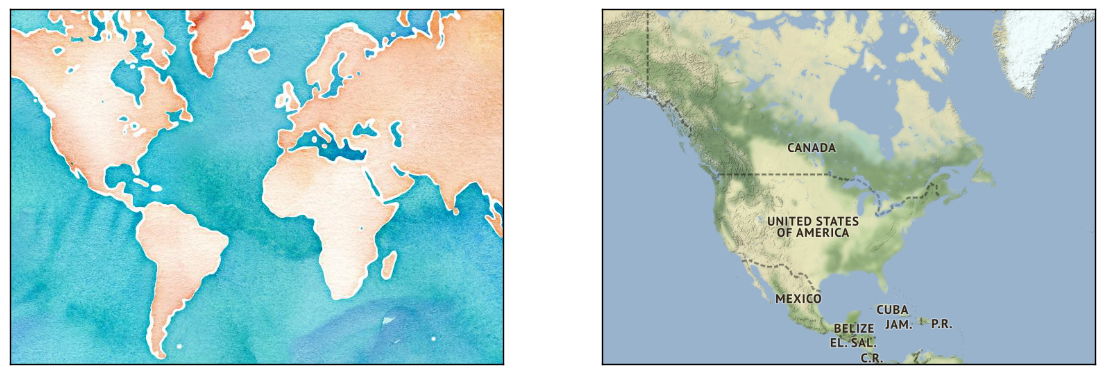

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)   #initialize 2 subplots within the figure

#load map first subplot: Exeter
m1 = geotiler.Map(center=(-20,20), zoom=2, size=(712,512))          # size affect the map geographical extend
m1.provider = geotiler.find_provider('stamen-watercolor')
image1 = geotiler.render_map(m1)
ax1.set_xticks([]) 
ax1.set_yticks([]) 
ax1.imshow(image1)

# 2nd map: Europe
m2 = geotiler.Map(center=(-90,47), zoom=3, size=(712,512))
m2.provider = geotiler.find_provider('stamen-terrain')
image2 = geotiler.render_map(m2)
ax2.set_xticks([]) 
ax2.set_yticks([]) 
ax2.imshow(image2)